In [1]:
import numpy as np
#from autograd import grad
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#import tensorflow as tf
#import torch
np.set_printoptions(suppress=True)

import warnings
#suppress warnings
warnings.filterwarnings('ignore')

year = 2014

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')
    
elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = X['N']

dist = X['distance']
tI1 = X['tI1'].reshape(N,1)
tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)
 
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

## Function

$$
\eta_{i}=\sum_{k=1}^{K} I_{k}^{(t)}(i)\left[\beta_{k}+\delta_{k}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}} \exp{\left(-\eta_{1k} s_{i}\right)}\right)+\gamma_{k} \sum_{j=1}^{M_{i}}\left(\frac{a_{j} z_{j}}{n_{z_{j}}} \exp{\left(-\eta_{2k} s_{j}\right)} w_{i j} \exp{\left(-\alpha_{k} d_{i j}\right)} I_{k}^{(s)}(j)\right)\right]
$$

## Derivatives

$$
\begin{align*}
\frac{\partial \eta_{i}}{\partial \beta_{k}} &= I_{k}^{(t)}(i) \\

\frac{\partial \eta_{i}}{\partial \delta_{k}} &= I_{k}^{(t)}(i)\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}}\right) \exp \left(-\eta_{1 k} s_{i}\right) \\

\frac{\partial \eta_{i}}{\partial \eta_{1 k}} &= -I_{k}^{(t)}(i) \delta_{k} s_{i}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}}\right) \exp \left(-\eta_{1 k} s_{i}\right) \\

\frac{\partial \eta_{i}}{\partial \eta_{2 k}} &= -\gamma_{k} I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z j}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j) s_{j}\right] \\

\frac{\partial \eta_{i}}{\partial \gamma_{k}} &= I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z_{j}}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j)\right] \\

\frac{\partial \eta_{i}}{\partial \alpha_{k}} &= -\gamma_{k} I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z_{j}}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j) d_{i j}\right]
\end{align*}
$$

### Cost Function

$$J(\theta) = 
-\frac{1}{N} \sum_{i=1}^{N} y_{i} \eta_{i}-n_{i} \log \left(1+e^{\eta_{i}}\right)
$$

In [2]:
# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * (y_may / n_may) * np.exp(-eta11 * s_may)
    auto_infection2 = beta2 + delta2 * (y_may / n_may) * np.exp(-eta12 * s_may)
    
    dispersal_component1 = gamma1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may), axis=0, keepdims=True).T
    dispersal_component2 = gamma2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2), axis=0, keepdims=True).T
    
    eta = tI1 * (auto_infection1 + dispersal_component1) + tI2 * (auto_infection2 + dispersal_component2)
    
    return eta


def costFunction(theta): 
    
    neg_log_likelihood = -(1/N) * np.sum(y_jun * eta(theta) - n_jun * np.log(1 + np.exp(eta(theta))))

    return neg_log_likelihood

# Numerical gradient of the cost function
#gradient = grad(costFunction)

### Gradient

$$\frac{\partial J}{\partial \theta} =
-\frac{1}{N}\sum_{i=1}^{N} \frac{\partial \eta_{i}}{\partial \theta}\left(y_{i}-\frac{n_{i}}{1+e^{-\eta_{i}}}\right)
$$


### Hessian

$$\frac{\partial^2 J}{\partial \theta^2} = -\frac{1}{N}
\sum_{i=1}^{N}\left[\frac{\partial^{2} \eta_{i}}{\partial \theta^{2}}\left(y_{i}-\frac{n_{i}}{1+e^{-\eta_{i}}}\right)- n_{i} \left(\frac{\partial \eta_{i}}{\partial \theta}\right)^{2}\frac{e^{-\eta_{i}}}{\left(1+e^{-\eta_{i}}\right)^2}\right]
$$

## Optimization

In [18]:
def partial(theta):
    
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    d_beta1 = tI1
    d_beta2 = tI2
    
    d_delta1 = tI1 * (y_may / n_may) * np.exp(-eta11 * s_may)
    d_delta2 = tI2 * (y_may / n_may) * np.exp(-eta12 * s_may)
    
    d_gamma1 = tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may), axis=0, keepdims=True).T
    d_gamma2 = tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2), axis=0, keepdims=True).T
    
    d_alpha1 = -gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * dist.T), axis=0, keepdims=True).T
    d_alpha2 = -gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * dist.T), axis=0, keepdims=True).T
    
    d_eta11 = -tI1 * delta1 * s_may * (y_may / n_may) * np.exp(-eta11 * s_may)
    d_eta12 = -tI2 * delta2 * s_may * (y_may / n_may) * np.exp(-eta12 * s_may)

    d_eta21 = -gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * s_may), axis=0, keepdims=True).T
    d_eta22 = -gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * s_may), axis=0, keepdims=True).T

    grad_entries = np.array([d_beta1, d_beta2, d_delta1, d_delta2, d_gamma1, d_gamma2, d_alpha1, d_alpha2, d_eta11, d_eta12, d_eta21, d_eta22])
    
    return grad_entries

def partial_by_partial(theta):
    
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    d_beta1 = tI1
    d_beta2 = tI2
    
    d_delta1 = tI1 * (y_may / n_may) * np.exp(-eta11 * s_may)
    d_delta2 = tI2 * (y_may / n_may) * np.exp(-eta12 * s_may)
    
    d_gamma1 = tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may), axis=0, keepdims=True).T
    d_gamma2 = tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2), axis=0, keepdims=True).T
    
    d_alpha1 = -gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * dist.T), axis=0, keepdims=True).T
    d_alpha2 = -gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * dist.T), axis=0, keepdims=True).T
    
    d_eta11 = -tI1 * delta1 * s_may * (y_may / n_may) * np.exp(-eta11 * s_may)
    d_eta12 = -tI2 * delta2 * s_may * (y_may / n_may) * np.exp(-eta12 * s_may)

    d_eta21 = -gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * s_may), axis=0, keepdims=True).T
    d_eta22 = -gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * s_may), axis=0, keepdims=True).T

    grad_entries = np.array([[d_beta1*d_beta1, d_beta2*d_beta1, d_delta1*d_beta1, d_delta2*d_beta1, d_gamma1*d_beta1, d_gamma2*d_beta1, d_alpha1*d_beta1, d_alpha2*d_beta1, d_eta11*d_beta1, d_eta12*d_beta1, d_eta21*d_beta1, d_eta22*d_beta1],
                            [d_beta1*d_beta2, d_beta2*d_beta2, d_delta1*d_beta2, d_delta2*d_beta2, d_gamma1*d_beta2, d_gamma2*d_beta2, d_alpha1*d_beta2, d_alpha2*d_beta2, d_eta11*d_beta2, d_eta12*d_beta2, d_eta21*d_beta2, d_eta22*d_beta2],
                            [d_beta1*d_delta1, d_beta2*d_delta1, d_delta1*d_delta1, d_delta2*d_delta1, d_gamma1*d_delta1, d_gamma2*d_delta1, d_alpha1*d_delta1, d_alpha2*d_delta1, d_eta11*d_delta1, d_eta12*d_delta1, d_eta21*d_delta1, d_eta22*d_delta1],
                            [d_beta1*d_delta2, d_beta2*d_delta2, d_delta1*d_delta2, d_delta2*d_delta2, d_gamma1*d_delta2, d_gamma2*d_delta2, d_alpha1*d_delta2, d_alpha2*d_delta2, d_eta11*d_delta2, d_eta12*d_delta2, d_eta21*d_delta2, d_eta22*d_delta2],
                            [d_beta1*d_gamma1, d_beta2*d_gamma1, d_delta1*d_gamma1, d_delta2*d_gamma1, d_gamma1*d_gamma1, d_gamma2*d_gamma1, d_alpha1*d_gamma1, d_alpha2*d_gamma1, d_eta11*d_gamma1, d_eta12*d_gamma1, d_eta21*d_gamma1, d_eta22*d_gamma1],
                            [d_beta1*d_gamma2, d_beta2*d_gamma2, d_delta1*d_gamma2, d_delta2*d_gamma2, d_gamma1*d_gamma2, d_gamma2*d_gamma2, d_alpha1*d_gamma2, d_alpha2*d_gamma2, d_eta11*d_gamma2, d_eta12*d_gamma2, d_eta21*d_gamma2, d_eta22*d_gamma2],
                            [d_beta1*d_alpha1, d_beta2*d_alpha1, d_delta1*d_alpha1, d_delta2*d_alpha1, d_gamma1*d_alpha1, d_gamma2*d_alpha1, d_alpha1*d_alpha1, d_alpha2*d_alpha1, d_eta11*d_alpha1, d_eta12*d_alpha1, d_eta21*d_alpha1, d_eta22*d_alpha1],
                            [d_beta1*d_alpha2, d_beta2*d_alpha2, d_delta1*d_alpha2, d_delta2*d_alpha2, d_gamma1*d_alpha2, d_gamma2*d_alpha2, d_alpha1*d_alpha2, d_alpha2*d_alpha2, d_eta11*d_alpha2, d_eta12*d_alpha2, d_eta21*d_alpha2, d_eta22*d_alpha2],
                            [d_beta1*d_eta11, d_beta2*d_eta11, d_delta1*d_eta11, d_delta2*d_eta11, d_gamma1*d_eta11, d_gamma2*d_eta11, d_alpha1*d_eta11, d_alpha2*d_eta11, d_eta11*d_eta11, d_eta12*d_eta11, d_eta21*d_eta11, d_eta22*d_eta11],
                            [d_beta1*d_eta12, d_beta2*d_eta12, d_delta1*d_eta12, d_delta2*d_eta12, d_gamma1*d_eta12, d_gamma2*d_eta12, d_alpha1*d_eta12, d_alpha2*d_eta12, d_eta11*d_eta12, d_eta12*d_eta12, d_eta21*d_eta12, d_eta22*d_eta12],
                            [d_beta1*d_eta21, d_beta2*d_eta21, d_delta1*d_eta21, d_delta2*d_eta21, d_gamma1*d_eta21, d_gamma2*d_eta21, d_alpha1*d_eta21, d_alpha2*d_eta21, d_eta11*d_eta21, d_eta12*d_eta21, d_eta21*d_eta21, d_eta22*d_eta21],
                            [d_beta1*d_eta22, d_beta2*d_eta22, d_delta1*d_eta22, d_delta2*d_eta22, d_gamma1*d_eta22, d_gamma2*d_eta22, d_alpha1*d_eta22, d_alpha2*d_eta22, d_eta11*d_eta22, d_eta12*d_eta22, d_eta21*d_eta22, d_eta22*d_eta22]])
    
    
    
    return grad_entries

def partial_sq(theta):
    
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    # delta1 second derivatives
    
    d_delta1_d_eta11 = -tI1 * (y_may / n_may) * np.exp(-eta11 * s_may) * s_may
    d_delta1_d_eta12 = 0
    
    d_delta2_d_eta11 = 0
    d_delta2_d_eta12 = -tI2 * (y_may / n_may) * np.exp(-eta12 * s_may) * s_may
    
    d_gamma1_d_eta21 = -tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * s_may), axis=0, keepdims=True).T
    d_gamma1_d_eta22 = 0
    d_gamma1_d_alpha1 = -tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * dist.T), axis=0, keepdims=True).T
    d_gamma1_d_alpha2 = 0
    
    d_gamma2_d_eta21 = 0
    d_gamma2_d_eta22 = -tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * s_may), axis=0, keepdims=True).T
    d_gamma2_d_alpha1 = 0
    d_gamma2_d_alpha2 = -tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * dist.T), axis=0, keepdims=True).T
    
    d_alpha1_d_gamma1 = -tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * dist.T), axis=0, keepdims=True).T
    d_alpha1_d_gamma2 = 0
    d_alpha1_d_eta21 = gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * dist.T * s_may), axis=0, keepdims=True).T
    d_alpha1_d_eta22 = 0
    d_alpha1_d_alpha1 = gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * (dist.T)**2), axis=0, keepdims=True).T
    d_alpha1_d_alpha2 = 0
    
    d_alpha2_d_gamma1 = 0
    d_alpha2_d_gamma2 = -tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * dist.T), axis=0, keepdims=True).T
    d_alpha2_d_eta21 = 0
    d_alpha2_d_eta22 = gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * dist.T * s_may), axis=0, keepdims=True).T
    d_alpha2_d_alpha1 = 0
    d_alpha2_d_alpha2 = gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * (dist.T)**2), axis=0, keepdims=True).T
    
    d_eta11_d_delta1 = -tI1 * s_may * (y_may / n_may) * np.exp(-eta11 * s_may)
    d_eta11_d_delta2 = 0
    d_eta11_d_eta11 = tI1 * delta1 * (s_may**2) * (y_may / n_may) * np.exp(-eta11 * s_may)
    d_eta11_d_eta12 = 0
    
    d_eta12_d_delta1 = 0
    d_eta12_d_delta2 = -tI2 * s_may * (y_may / n_may) * np.exp(-eta12 * s_may)
    d_eta12_d_eta11 = 0
    d_eta12_d_eta12 = tI2 * delta2 * (s_may**2) * (y_may / n_may) * np.exp(-eta12 * s_may)
    
    d_eta21_d_gamma1 = -tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * s_may), axis=0, keepdims=True).T
    d_eta21_d_gamma2 = 0
    d_eta21_d_eta21 = gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * (s_may**2)), axis=0, keepdims=True).T
    d_eta21_d_eta22 = 0
    d_eta21_d_alpha1 = gamma1 * tI1 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta21 * s_may) * (w_may * np.exp(-alpha1 * dist)).T * sI1_may * s_may * (dist.T)), axis=0, keepdims=True).T
    d_eta21_d_alpha2 = 0
    
    d_eta22_d_gamma1 = 0
    d_eta22_d_gamma2 = -tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * s_may), axis=0, keepdims=True).T
    d_eta22_d_eta21 = 0
    d_eta22_d_eta22 = gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * (s_may**2)), axis=0, keepdims=True).T
    d_eta22_d_alpha1 = 0
    d_eta22_d_alpha2 = gamma2 * tI2 * np.sum(((a_may * (y_may / n_may)) * np.exp(-eta22 * s_may) * (w_may * np.exp(-alpha2 * dist)).T * sI2 * s_may * (dist.T)), axis=0, keepdims=True).T
    
    zero = np.zeros((N, 1))
    
    hess_entries = np.array([[zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero],    #d_beta1
                             [zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero, zero],    #d_beta2
                             [zero, zero, zero, zero, zero, zero, zero, zero, d_eta11_d_delta1, zero, zero, zero],    #d_delta1
                             [zero, zero, zero, zero, zero, zero, zero, zero, zero, d_eta12_d_delta2, zero, zero],    #d_delta2
                             [zero, zero, zero, zero, zero, zero, d_alpha1_d_gamma1, zero, zero, zero, d_eta21_d_gamma1, zero],    #d_gamma1
                             [zero, zero, zero, zero, zero, zero, zero, d_alpha2_d_gamma2, zero, zero, zero, d_eta22_d_gamma2],    #d_gamma2
                             [zero, zero, zero, zero, d_gamma1_d_alpha1, zero, d_alpha1_d_alpha1, zero, zero, zero, d_eta21_d_alpha1, zero],    #d_alpha1
                             [zero, zero, zero, zero, zero, d_gamma2_d_alpha2, zero, d_alpha2_d_alpha2, zero, zero, zero, d_eta22_d_alpha2],    #d_alpha2
                             [zero, zero, d_delta1_d_eta11, zero, zero, zero, zero, zero, d_eta11_d_eta11, zero, zero, zero],    #d_eta11
                             [zero, zero, zero, d_delta2_d_eta12, zero, zero, zero, zero, zero, d_eta12_d_eta12, zero, zero],    #d_eta12
                             [zero, zero, zero, zero, d_gamma1_d_eta21, zero, d_alpha1_d_eta21, zero, zero, zero, d_eta21_d_eta21, zero],    #d_eta21
                             [zero, zero, zero, zero, zero, d_gamma2_d_eta22, zero, d_alpha2_d_eta22, zero, zero, zero, d_eta22_d_eta22]])   #d_eta22
    
    
    return hess_entries



# Gradient
def gradient(theta):
    
    mu = y_jun - (n_jun / (1 + np.exp(-eta(theta))))
    
    # Gradient entries
    gradient = - (1 / N) * np.sum((partial(theta) * mu), axis=1)
    
    return gradient


# Hessian
def hessian(theta):
    
    mu = y_jun - (n_jun / (1 + np.exp(-eta(theta))))
    
    # Hessian entries
    hessian = - (1 / N) * np.sum((partial_sq(theta) * mu - n_jun * (partial_by_partial(theta)) * (np.exp(-eta(theta)) / (1 + np.exp(-eta(theta)))**2)), axis=2)
    hessian = hessian.reshape((12, 12))
    
    return hessian


# Adam optimizer
def adam(theta, alpha, num_iters, b_1=0.9, b_2=0.999, eps=1e-8, tolerance=1e-6):

    # Make a copy of theta, to avoid changing the original array, since numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # Use a python list to save cost in every iteration
    J_history = []
    
    m = np.zeros(theta.shape)
    v = np.zeros(theta.shape)
    
    for i in range(num_iters):
        
        # Gradient
        g = gradient(theta)

        # First moment
        m = b_1 * m + (1 - b_1) * g

        # Second moment
        v = b_2 * v + (1 - b_2) * g**2

        # Bias correction for the first and second moments

        mhat = m / (1 - b_1**(i+1))

        vhat = v / (1 - b_2**(i+1))
        
        change = alpha * mhat / (np.sqrt(vhat) + eps)
        
        # Update parameter theta
        theta = theta - change
        
        # save the cost J in every iteration
        J_history.append(costFunction(theta))
        # report progress
        print('#', i , 'cost: ', costFunction(theta), 'MaxGrad: ', np.max(np.abs(gradient(theta))), 'MinEig: ', np.min(np.linalg.eigvalsh(hessian(theta))))
        
        if (np.max(np.abs(gradient(theta))) <= tolerance) & (np.min(np.linalg.eigvalsh(hessian(theta))) > 0):
            break
        
    return theta, J_history


# Gradient descent algorithm
def gradientDescent(theta, alpha, num_iters):

    # Make a copy of theta, to avoid changing the original array, since numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # Use a python list to save cost in every iteration
    J_history = []
    
    # Update parameter theta using the gradient
    for i in range(num_iters):
        
        theta = theta - alpha * gradient(theta)
        
        # save the cost J in every iteration
        J_history.append(costFunction(theta))
        # report progress
        #print('iteration: ', i, 'cost: ', costFunction(theta), 'normGradient: ', np.linalg.norm(gradient(theta)))
    return theta, J_history


# AdaGrad algorithm
def adagrad(theta, alpha, num_iters, eps=1e-8):

    # Make a copy of theta, to avoid changing the original array, since numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # Use a python list to save cost in every iteration
    J_history = []
    
    # Update parameter theta using the gradient
    for i in range(num_iters):
        g = gradient(theta)
        
        theta = theta - (alpha / (eps + np.sqrt(g**2))) * g
        
        # save the cost J in every iteration
        J_history.append(costFunction(theta))
        # report progress
        #print('iteration: ', i, 'cost: ', costFunction(theta))
    return theta, J_history

# 0 cost:  66.5529490621282 MaxGrad:  28.59723229296847 MinEig:  -25.35104651841701
# 1 cost:  64.66882975670536 MaxGrad:  27.692792235690955 MinEig:  -46.081752508843266
# 2 cost:  62.743564595435856 MaxGrad:  26.788208486774774 MinEig:  -30.810656332809366
# 3 cost:  60.914476805606824 MaxGrad:  25.8700091706016 MinEig:  -14.367728807628687
# 4 cost:  59.774869290553454 MaxGrad:  24.92537570090403 MinEig:  -22.52998090718159
# 5 cost:  58.18646644413032 MaxGrad:  23.93472529140024 MinEig:  -37.47379390471244
# 6 cost:  56.40220127528901 MaxGrad:  22.864735730218626 MinEig:  -64.9060258699466
# 7 cost:  54.60930360605249 MaxGrad:  21.657150737803768 MinEig:  -115.22628008189885
# 8 cost:  52.63901988643775 MaxGrad:  20.20870940581555 MinEig:  -205.00241635321044
# 9 cost:  50.21181779801834 MaxGrad:  32.08926717050587 MinEig:  -350.37918774436366
# 10 cost:  47.01762625500337 MaxGrad:  52.52555047949703 MinEig:  -520.7349574331139
# 11 cost:  42.80922408310363 MaxGrad:  75.99538665730

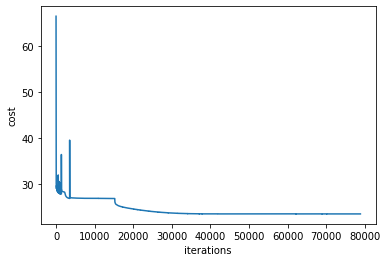

In [19]:
# initialize fitting parameters

# Xavier initialization for theta
theta = np.random.normal(0, 1 / np.sqrt(N), size=(12, 1))

# Use below theta to continue from checkpoint
#checkpoint = np.load('../reports/may_jun_2014.npy', allow_pickle=True)
#theta = checkpoint[0]

#theta = np.load('../reports/theta2.npy')

# Gradient descent settings
iterations = 1000000

alpha = 0.05 # learning rate

theta, J_history = adam(theta, alpha, iterations)

#print('iteration start:\t{:.3f}'.format(np.int32(checkpoint[1])))
#print('previous final cost:\t{:.3f}'.format(checkpoint[2]))
print('updated final cost:\t{:.3f}'.format(J_history[-1]))
#print('theta: \n', theta)

plt.plot(list(range(1, len(J_history) + 1)), J_history)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

# Save trained parameters

#iterations += checkpoint[1]
checkpoint = np.array([theta, iterations, J_history], dtype=object)
np.save('../reports/may_jun_2014.npy', checkpoint)

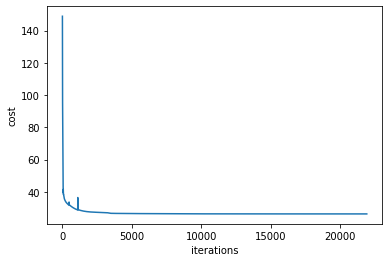

In [21]:
plt.plot(list(range(1, len(J_history) + 1)), J_history)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

In [50]:
#checkpoint = np.array([theta, iterations, J_history], dtype=object)
#np.save('../reports/checkpoint_June_July2_backup.npy', checkpoint)

In [45]:
checkpoint = np.load('../reports/checkpoint_June_July2.npy', allow_pickle=True)
theta = checkpoint[0]

In [23]:
theta

array([[  -3.59177932],
       [  -3.94915196],
       [1119.55420121],
       [  52.31834726],
       [ 976.01697066],
       [   1.66059847],
       [   0.79180267],
       [   4.18306803],
       [   3.0279384 ],
       [   0.85356801],
       [   2.3127207 ],
       [  -3.26482255]])

## Parameter Estimation

## Function

$$
\eta_{i}=\sum_{k=1}^{K} I_{k}^{(t)}(i)\left[\beta_{k}+\delta_{k}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}} \exp{\left(-\eta_{1k} s_{i}\right)}\right)+\gamma_{k} \sum_{j=1}^{M_{i}}\left(\frac{a_{j} z_{j}}{n_{z_{j}}} \exp{\left(-\eta_{2k} s_{j}\right)} w_{i j} \exp{\left(-\alpha_{k} d_{i j}\right)} I_{k}^{(s)}(j)\right)\right]
$$

$$\beta_1 = -2.89902093$$
$$\beta_2 = -4.33376942$$
$$\delta_1 = 3.86406603$$
$$\delta_2 = 7.1830044$$
$$\gamma_1 = 0.06209235$$
$$\gamma_2 = 6.21221296$$
$$\alpha_1 = 0.17578305$$
$$\alpha_2 = 1.31264131$$
$$\eta_{11} = 0.13978209$$
$$\eta_{12} = 0.40521989$$
$$\eta_{21} = -0.79182359$$
$$\eta_{22} = 0.55742334$$

## Eigenvalues of Hessian

In [24]:
np.linalg.eigvalsh(hessian(theta))

array([ 0.        ,  0.00000135,  0.00015515,  0.02210959,  0.1156512 ,
        0.34274319,  1.27697895,  1.89804529,  3.40243372,  3.6481131 ,
       47.10058366, 73.60512815])

## Gradient

In [25]:
gradient(theta)

array([[-0.00000025],
       [-0.00000003],
       [-0.000001  ],
       [-0.00000001],
       [ 0.00000001],
       [-0.00000002],
       [ 0.00000085],
       [ 0.00000004],
       [-0.00000096],
       [ 0.00000002],
       [ 0.00000057],
       [ 0.00000025]])

In [31]:
nGrad = nd.Gradient(costFunction)
nHess = nd.Hessian(costFunction)
hess_theta = nHess(theta.reshape(12,))
grad_theta = nGrad(theta.reshape(12,))

In [28]:
def prob(theta):
    
    p = 1 / (1 + np.exp(-eta(theta)))
    
    return p

In [29]:
print('estimated probability of disease: \n', prob(theta))

estimated probability of disease: 
 [[0.01898989]
 [0.01897345]
 [0.01899577]
 [0.01916661]
 [0.01895953]
 [0.01893507]
 [0.01910427]
 [0.04191025]
 [0.07665225]
 [0.40547538]
 [0.0270297 ]
 [0.02988538]
 [0.04097176]
 [0.05864899]
 [0.01898016]
 [0.01897609]
 [0.01897959]
 [0.01969532]
 [0.02021772]
 [0.02393826]
 [0.0189389 ]
 [0.02226927]
 [0.5       ]
 [0.99996867]
 [0.53665621]
 [0.23485776]
 [0.24192465]
 [0.23603945]
 [0.5551613 ]
 [0.71788949]
 [0.40967543]
 [0.5232486 ]
 [0.83528412]
 [0.02702044]
 [0.02682359]
 [0.01890669]
 [0.01890669]
 [0.01890669]
 [0.01890669]
 [0.02702363]
 [0.01890669]
 [0.01890669]
 [0.01890669]
 [0.01891385]
 [0.01890926]
 [0.01891418]
 [0.5       ]
 [0.01894565]
 [0.01894515]
 [0.13460278]
 [0.17997862]
 [0.19323309]
 [0.18921143]
 [0.02701562]
 [0.02700933]
 [0.01890669]
 [0.02709245]
 [0.01890669]
 [0.02711502]
 [0.01890669]
 [0.02723751]
 [0.01890669]
 [0.01890669]
 [0.01890669]
 [0.01890673]
 [0.01890672]
 [0.01890673]
 [0.5       ]
 [0.01891601

In [30]:
prob(theta).shape

(104, 1)